In [14]:
import numpy as np
import pandas as pd
import json
import os
from epilepsypcm.utils.outcome_params import node_location, early_propogation, irritative_zone

import warnings
warnings.filterwarnings('ignore')

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.models.base_models import *
from sklearn.metrics import auc

all_positive_patients = pd.read_csv("df_final.csv", sep = ',').reset_index(drop = True)
print(all_positive_patients["outcome"].value_counts())


0.0    259
1.0     56
Name: outcome, dtype: int64


Optimal roc threshold:  0.22


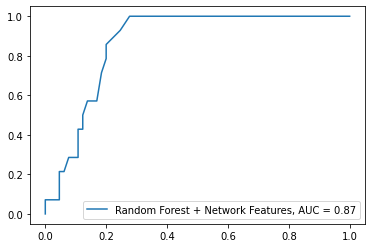

In [15]:
# training model

plot_roc = False
plot_pr = False

X_list = ["Channels", "SigResp", "N1RespAvg", "N1RespSDV", "N2RespAvg", "N2RespSDV", "P2RespAvg", "P2RespSDV", 
          "SigStim", "N1StimAvg", "N1StimSDV", "N2StimAvg", "N2StimSDV", "P2StimAvg", "P2StimSDV",
         "InDegree", "OutDegree", "EV", "Closeness"] #including IZ and EP in model boost auc from 0.83 to 0.87

smote = False
max_depth = 20
rf, test_channels, y_pred, y_test, tpr, fpr, roc_thresholds, precision, recall = random_forest(all_positive_patients, X_list, max_depth, plot_roc, plot_pr, smote)
plt.plot(fpr, tpr, label = "Random Forest + Network Features, AUC = %0.2f" % auc(fpr, tpr))
plt.legend(loc='lower right')

optimal_thresh = roc_thresholds[np.argmax(tpr - fpr)]
print("Optimal roc threshold: ", optimal_thresh)

In [16]:
all_neg_patients = pd.read_csv("unsuccessful_DF.csv", sep = ',', index_col = 0)
all_neg_patients.head()

,Channels,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,P2RespAvg,P2RespSDV,N1StimAvg,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV,patient,InDegree,OutDegree,EV,Closeness
0,RA7_RA8,0.470588,0.235294,11.275250,13.430507,12.300852,17.797695,10.693199,13.013718,5.385827,5.037416,8.653968,8.250072,6.505716,4.873793,PY21N007,0.444444,0.222222,1.839785e-01,0.600000
1,RA8_RA9,0.411765,0.294118,11.349622,14.409670,15.607462,22.626955,9.325437,7.232690,5.110791,4.167502,5.253412,4.484553,5.456525,4.048721,PY21N007,0.388889,0.277778,1.687278e-01,0.580645
2,RH1_RH2,0.166667,0.277778,18.722890,47.849258,9.351465,17.359378,7.040116,16.182438,20.063484,41.903112,7.045011,12.544347,9.430739,13.200236,PY21N007,0.166667,0.277778,1.150292e-01,0.514286
3,RH5_RH6,0.777778,0.500000,17.155535,12.812753,6.383174,4.995149,11.223168,7.985343,13.980816,17.902728,18.496704,23.920131,9.152502,11.720191,PY21N007,0.777778,0.500000,3.212952e-01,0.818182
4,RHG1_RHG2,0.166667,0.666667,6.654436,13.721655,2.825886,2.155459,3.864567,6.131093,15.076088,10.356663,4.687854,4.377788,9.564763,8.984542,PY21N007,0.166667,0.666667,7.137374e-07,0.166667


In [17]:
patient_list = all_neg_patients["patient"].value_counts().index

one_count = 0
all_count = 0

for patient in patient_list:
    
    sub_df = all_neg_patients[all_neg_patients.patient == patient]
    
    X_test = sub_df.drop(columns=["Channels", "patient"])
    outcome_pred = rf.predict_proba(X_test)[:, 1]
    outcome_pred_rounded = np.where(outcome_pred > optimal_thresh, 1, 0)
    
    df_output = pd.DataFrame()
    df_output["Channels"] = sub_df["Channels"]
    df_output["Predicted Outcome"] = outcome_pred_rounded
    df_output["Probability of Outcome"] = outcome_pred
    
    one_count += list(outcome_pred_rounded).count(1)
    all_count += len(outcome_pred_rounded)
    
    df_output = df_output.sort_values(by = ["Probability of Outcome"])
    
    if os.path.exists(("unsuccesful_outcome_predictions/")) == False:
        os.makedirs(("unsuccesful_outcome_predictions/"))

    df_output.to_csv(("unsuccesful_outcome_predictions/" + patient + ".csv"))

print("% of 1s across predictions", (one_count/all_count))

% of 1s across predictions 0.6756756756756757
